# Visual Testing

Some subtle and unusual errors in signal reconstruction can creep in if certain parts of the symmetric decorrelation routine are bugged; accordingly, even if the automated test comparing the reconstructed signals against each other passes, it is important to look at the graph in person and verify that it looks reasonable.

This code is based off the Blind Source Separation notebook included in Scikit-learn's example library:
https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#blind-source-separation-using-fastica

In [3]:
import fastica

In [4]:
%matplotlib inline
%load_ext cython

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, linalg
from sklearn.decomposition import _fastica as sk_fastica

In [5]:
gen_test_signals = fastica.TestSignalReconstruction.gen_test_signals

In [6]:
X, A, S = gen_test_signals()
W = np.random.normal(size=A.shape)

In [7]:
sk_ica = sk_fastica.FastICA(n_components=3,
                            w_init=np.copy(W),
                            whiten_solver='svd',
                            whiten='unit-variance',
                            # defaults
                            max_iter=200,
                            tol=1e-04)

In [8]:
sk_S = sk_ica.fit_transform(np.copy(X.T)).T
sk_A = sk_ica.mixing_

In [9]:
X0 = np.copy(X)
X1, K, cy_mean = fastica.whiten(X0, 3)
cy_W, n_iter = fastica.fastica(X1, np.copy(W))

cy_S = fastica.recover_S_from_WX1(cy_W, X1)
cy_A = fastica.recover_A_from_WK(cy_W, K)

unit_S = np.copy(cy_S)
unit_A = np.copy(cy_A)
fastica.scale_to_unit_variance(unit_S, unit_A.T)

array([0.02236068, 0.02236068, 0.02236068])

In [10]:
X.shape

(3, 2000)

In [11]:
print(f'SK iterations: {sk_ica.n_iter_}')
print(f'CY iterations: {n_iter}')

SK iterations: 3
CY iterations: 3


In [12]:
# Basic check (also in test_fastica)
sk_X = np.dot(sk_A, sk_S) + sk_ica.mean_[:, np.newaxis]
cy_X = np.dot(cy_A, cy_S) + cy_mean[:, np.newaxis]
unit_X = np.dot(unit_A, unit_S) + cy_mean[:, np.newaxis]

assert np.allclose(sk_X, X)
assert np.allclose(cy_X, X)
assert np.allclose(unit_X, X)
assert np.allclose(sk_X, cy_X)

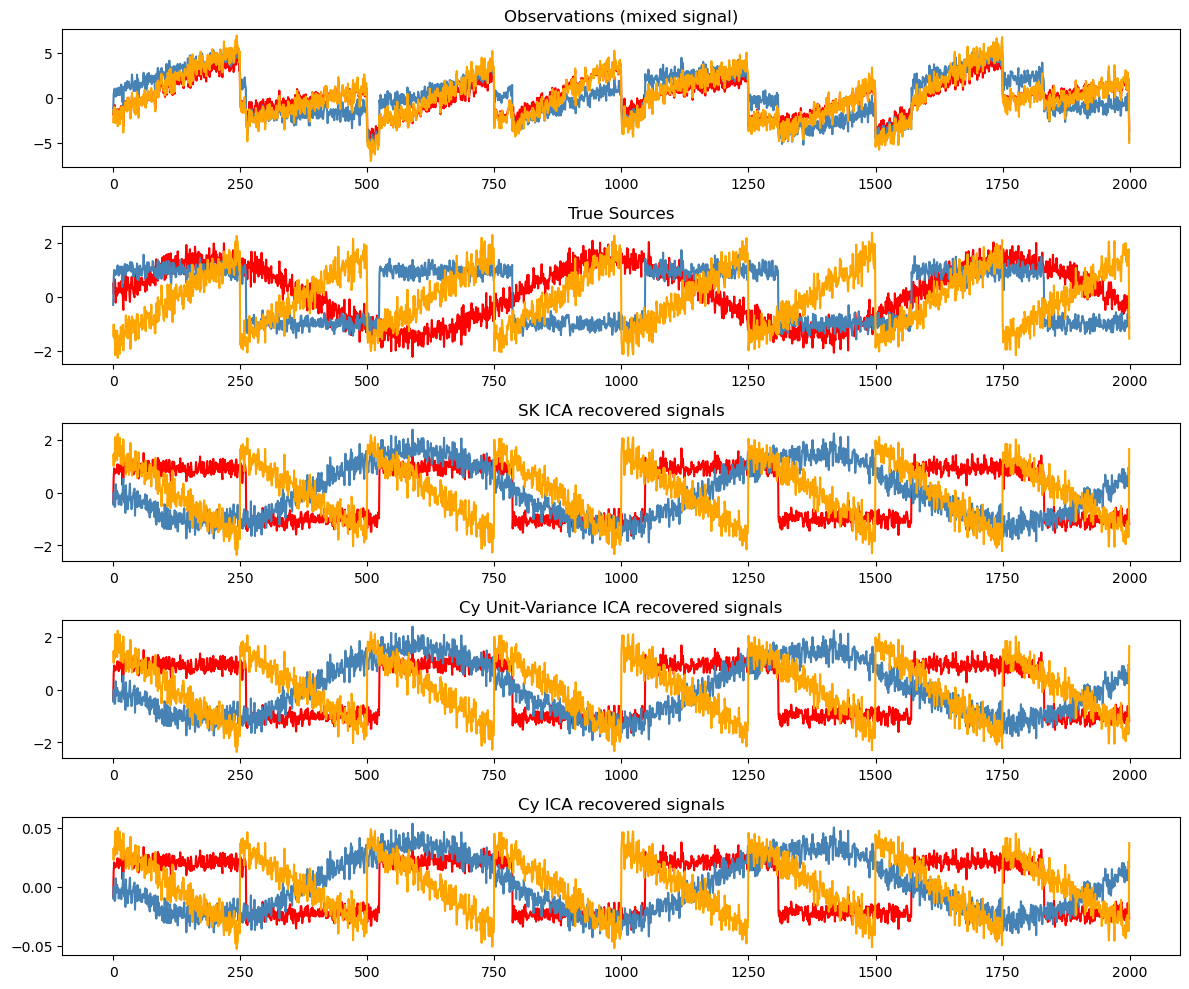

In [13]:
plt.figure(figsize=(12, 10))

models = [X.T, S.T, sk_S.T, unit_S.T, cy_S.T]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "SK ICA recovered signals",
    "Cy Unit-Variance ICA recovered signals",
    "Cy ICA recovered signals"
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(5, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

# Toy Data Timing

In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [15]:
%%timeit
timing_ica = sk_fastica.FastICA(n_components=3,
                                w_init=np.copy(W),
                                whiten_solver='eigh',
                                whiten='unit-variance',
                                max_iter=2000,
                                tol=0)
timing_ica.fit_transform(np.copy(X.T))

1.19 s ± 4.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
X0 = np.copy(X)
X1, K, cy_mean = fastica.whiten(X0, 3)
cy_W, n_iter = fastica.fastica(X1, np.copy(W), max_iter=2000, tol=0)

cy_S = fastica.recover_S_from_WX1(cy_W, X1)
cy_A = fastica.recover_A_from_WK(cy_W, K)
fastica.scale_to_unit_variance(cy_S, cy_A.T)

167 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
